In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import datetime
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn import metrics
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit, TimeSeriesSplit
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, make_scorer, roc_curve


sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# **Pre**

In [ ]:
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE, MAX_ROWS=300000):

    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    num_rows = 0
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        num_rows += len(df)
        if num_rows >= MAX_ROWS:
            break
    df_final = pd.concat(frames)

    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data
    df_final=df_final.replace([-1],0)

    return df_final

In [ ]:
DIR_INPUT='/content/drive/MyDrive/Tesis/Final_3/'

BEGIN_DATE = "2023-01-01"
END_DATE = "2023-05-31"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.CARDING.sum()))

Load  files
CPU times: user 587 ms, sys: 509 ms, total: 1.1 s
Wall time: 30.5 s
303868 transactions loaded, containing 178 fraudulent transactions


In [ ]:
n_folds = 4

Taking into account only 10 features

In [ ]:
output_feature="CARDING"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'WEB_ID']

In [ ]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])

    return (train,test)

# Modelo

In [ ]:
X = transactions_df[input_features]
y = transactions_df[output_feature]

smote = SMOTE(sampling_strategy=0.002)

X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame({'CARDING': y_resampled})], axis=1)

In [ ]:
df_resampled['CARDING'].value_counts()

CARDING
0    303690
1       607
Name: count, dtype: int64

## LR

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled[input_features],
                                                        df_resampled[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0008297564060002474
Average Recall: 0.834096109839817


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60395 ocurrencias
Clase 1: 465 ocurrencias
Longitud test set:  60860


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 40147 ocurrencias
Clase 1: 20713 ocurrencias
Longitud test set:  60860


In [ ]:
thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.016752763964659877
Test Recall: 0.7462365591397849
Test CM: [[40029 20366]
 [  118   347]]
THRESHOLD:  0.1
Test Precision: 0.01035201326491743
Test Recall: 0.9935483870967742
Test CM: [[16228 44167]
 [    3   462]]
THRESHOLD:  0.05
Test Precision: 0.009273137877970301
Test Recall: 0.9978494623655914
Test CM: [[10822 49573]
 [    1   464]]
THRESHOLD:  0.01
Test Precision: 0.008186187349259723
Test Recall: 1.0
Test CM: [[ 4057 56338]
 [    0   465]]
THRESHOLD:  0.005
Test Precision: 0.007968605408369606
Test Recall: 1.0
Test CM: [[ 2506 57889]
 [    0   465]]
THRESHOLD:  0.001
Test Precision: 0.007732730235806698
Test Recall: 1.0
Test CM: [[  726 59669]
 [    0   465]]


<ipython-input-95-037e2645d9ba>:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


60859
0.9773812672743811


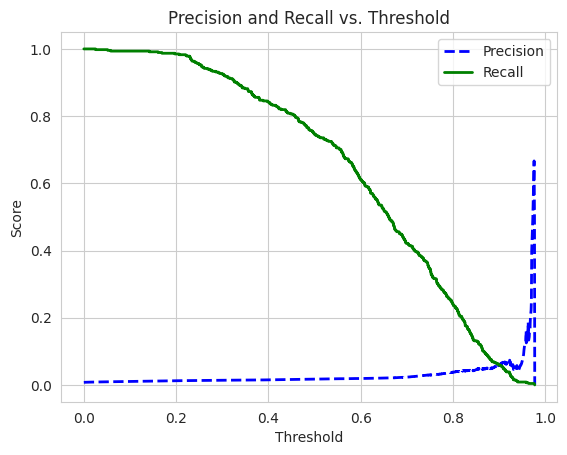

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

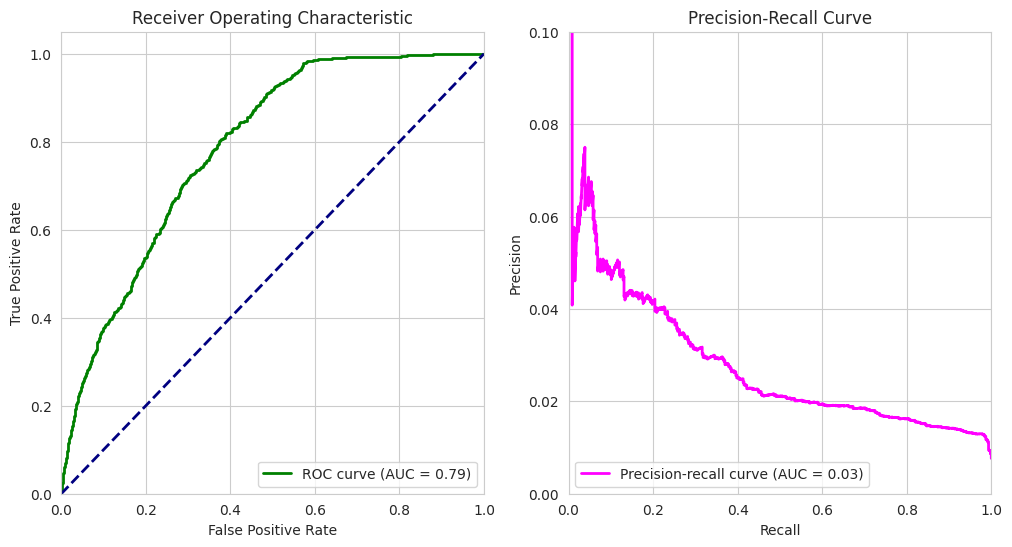

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.2f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 0.1])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## DT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled[input_features],
                                                        df_resampled[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4, random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0010388209978024858
Average Recall: 0.7572463768115942


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60395 ocurrencias
Clase 1: 465 ocurrencias
Longitud test set:  60860


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 41027 ocurrencias
Clase 1: 19833 ocurrencias
Longitud test set:  60860


In [ ]:
thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.020823879392930972
Test Recall: 0.8881720430107527
Test CM: [[40975 19420]
 [   52   413]]
THRESHOLD:  0.1
Test Precision: 0.014050656313551489
Test Recall: 0.9806451612903225
Test CM: [[28397 31998]
 [    9   456]]
THRESHOLD:  0.05
Test Precision: 0.01342972170795498
Test Recall: 0.9827956989247312
Test CM: [[26823 33572]
 [    8   457]]
THRESHOLD:  0.01
Test Precision: 0.012263247499467972
Test Recall: 0.9913978494623656
Test CM: [[23264 37131]
 [    4   461]]
THRESHOLD:  0.005
Test Precision: 0.012263247499467972
Test Recall: 0.9913978494623656
Test CM: [[23264 37131]
 [    4   461]]
THRESHOLD:  0.001
Test Precision: 0.012263247499467972
Test Recall: 0.9913978494623656
Test CM: [[23264 37131]
 [    4   461]]


10
0.842991147232892


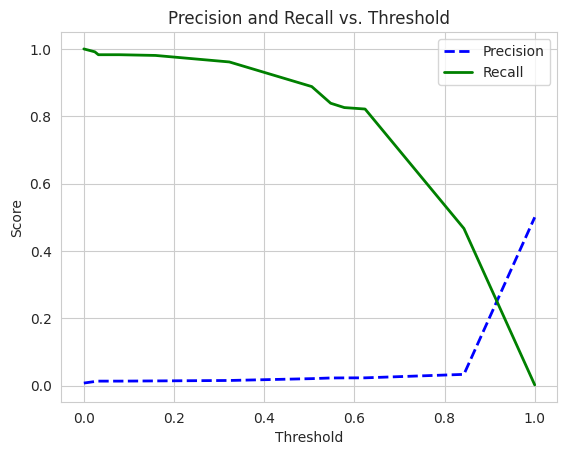

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

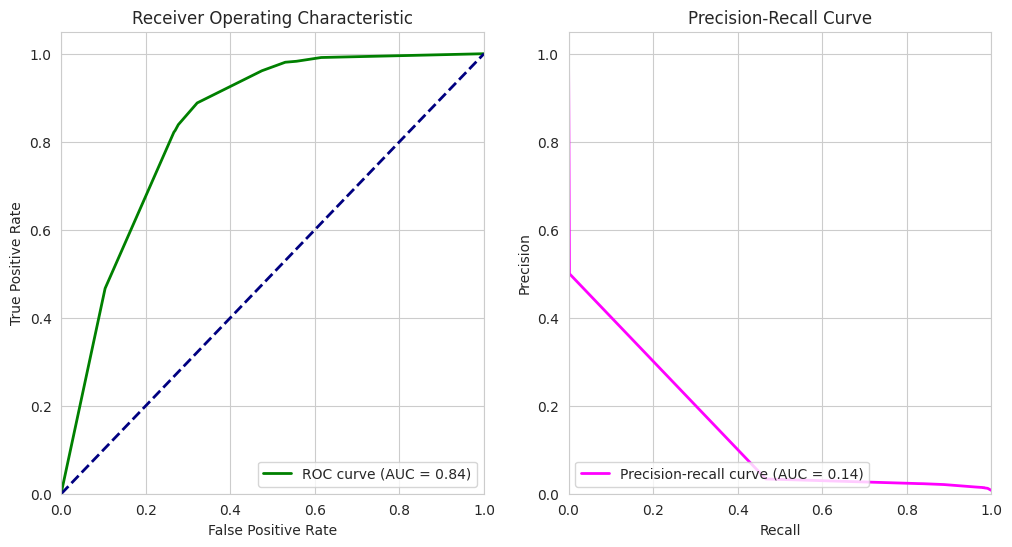

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.2f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## RF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled[input_features],
                                                        df_resampled[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0019689412507722954
Average Recall: 0.1883295194508009


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60395 ocurrencias
Clase 1: 465 ocurrencias
Longitud test set:  60860


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60594 ocurrencias
Clase 1: 266 ocurrencias
Longitud test set:  60860


In [ ]:
thresholds = [0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.9962406015037594
Test Recall: 0.5698924731182796
Test CM: [[60394     1]
 [  200   265]]
THRESHOLD:  0.25
Test Precision: 0.9590643274853801
Test Recall: 0.7053763440860215
Test CM: [[60381    14]
 [  137   328]]
THRESHOLD:  0.1
Test Precision: 0.6530612244897959
Test Recall: 0.8258064516129032
Test CM: [[60191   204]
 [   81   384]]
THRESHOLD:  0.05
Test Precision: 0.34104541559554413
Test Recall: 0.8559139784946237
Test CM: [[59626   769]
 [   67   398]]
THRESHOLD:  0.01
Test Precision: 0.047165729121592385
Test Recall: 0.9376344086021505
Test CM: [[51587  8808]
 [   29   436]]
THRESHOLD:  0.005
Test Precision: 0.047165729121592385
Test Recall: 0.9376344086021505
Test CM: [[51587  8808]
 [   29   436]]
THRESHOLD:  0.001
Test Precision: 0.047165729121592385
Test Recall: 0.9376344086021505
Test CM: [[51587  8808]
 [   29   436]]


18
0.18


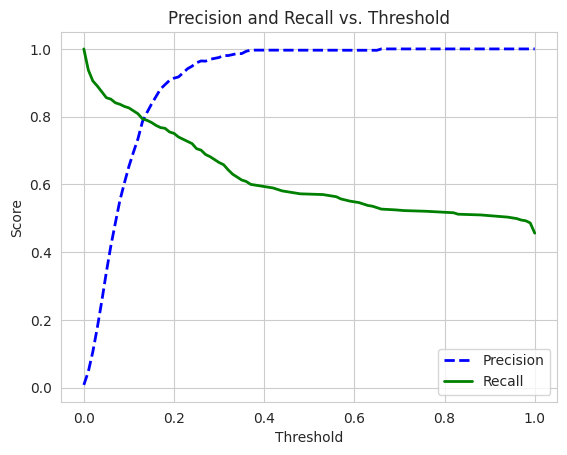

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

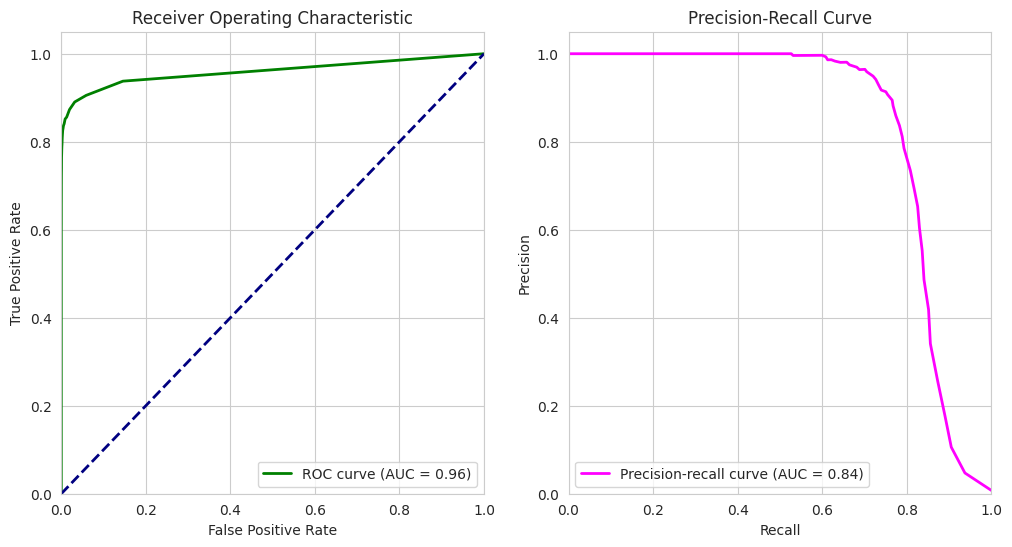

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.2f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

# Modelo 2

In [ ]:
X = transactions_df[input_features]
y = transactions_df[output_feature]

smote = SMOTE(sampling_strategy=0.001)

X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame({'CARDING': y_resampled})], axis=1)

In [ ]:
df_resampled['CARDING'].value_counts()

CARDING
0    303690
1       303
Name: count, dtype: int64

## LR

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled[input_features],
                                                        df_resampled[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0008455966510727267
Average Recall: 0.8143592677345538


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60638 ocurrencias
Clase 1: 161 ocurrencias
Longitud test set:  60799


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 39499 ocurrencias
Clase 1: 21300 ocurrencias
Longitud test set:  60799


In [ ]:
thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.0058215962441314556
Test Recall: 0.7701863354037267
Test CM: [[39462 21176]
 [   37   124]]
THRESHOLD:  0.1
Test Precision: 0.0034799251816085954
Test Recall: 0.9937888198757764
Test CM: [[14820 45818]
 [    1   160]]
THRESHOLD:  0.05
Test Precision: 0.003129768005946559
Test Recall: 0.9937888198757764
Test CM: [[ 9676 50962]
 [    1   160]]
THRESHOLD:  0.01
Test Precision: 0.0028044383284850805
Test Recall: 1.0
Test CM: [[ 3390 57248]
 [    0   161]]
THRESHOLD:  0.005
Test Precision: 0.002740518826172806
Test Recall: 1.0
Test CM: [[ 2051 58587]
 [    0   161]]
THRESHOLD:  0.001
Test Precision: 0.0026714010751974515
Test Recall: 1.0
Test CM: [[  531 60107]
 [    0   161]]


60786
0.9629048567823312


<ipython-input-134-037e2645d9ba>:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


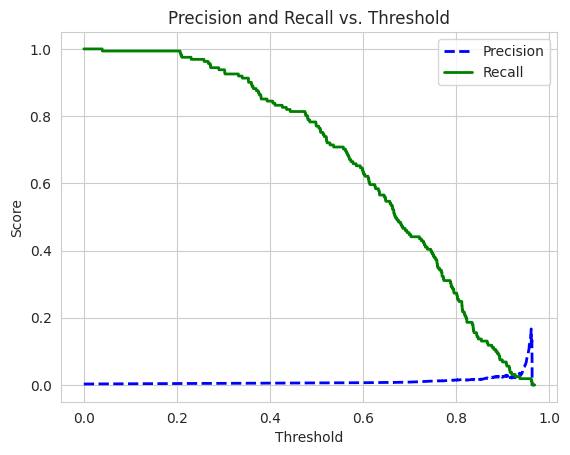

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

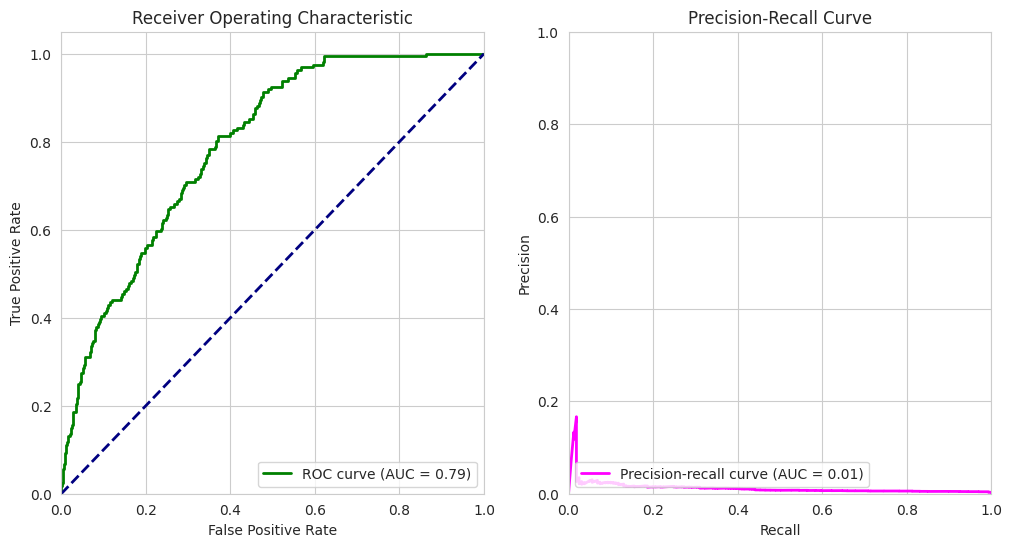

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.2f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 1])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## DT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled[input_features],
                                                        df_resampled[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4, random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0010317177474204013
Average Recall: 0.7572463768115942


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60638 ocurrencias
Clase 1: 161 ocurrencias
Longitud test set:  60799


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 41174 ocurrencias
Clase 1: 19625 ocurrencias
Longitud test set:  60799


In [ ]:
thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.0074394904458598725
Test Recall: 0.906832298136646
Test CM: [[41159 19479]
 [   15   146]]
THRESHOLD:  0.1
Test Precision: 0.004967247213684766
Test Recall: 0.9937888198757764
Test CM: [[28587 32051]
 [    1   160]]
THRESHOLD:  0.05
Test Precision: 0.004730928444707274
Test Recall: 0.9937888198757764
Test CM: [[26978 33660]
 [    1   160]]
THRESHOLD:  0.01
Test Precision: 0.004270880602194165
Test Recall: 0.9937888198757764
Test CM: [[23335 37303]
 [    1   160]]
THRESHOLD:  0.005
Test Precision: 0.004270880602194165
Test Recall: 0.9937888198757764
Test CM: [[23335 37303]
 [    1   160]]
THRESHOLD:  0.001
Test Precision: 0.004270880602194165
Test Recall: 0.9937888198757764
Test CM: [[23335 37303]
 [    1   160]]


10
1.0


<ipython-input-146-037e2645d9ba>:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


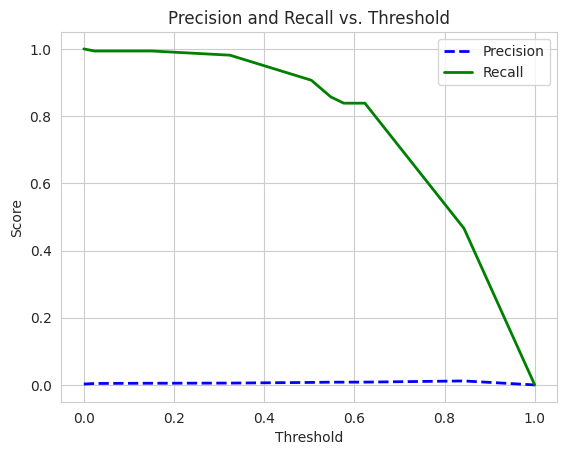

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

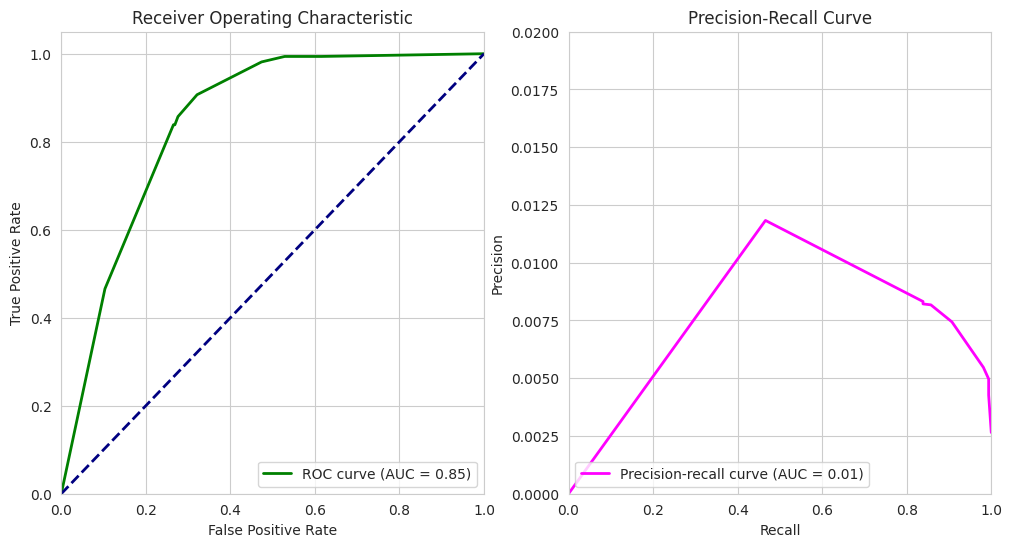

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.2f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 0.02])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## RF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled[input_features],
                                                        df_resampled[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.002828790623535668
Average Recall: 0.2707475209763539


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60638 ocurrencias
Clase 1: 161 ocurrencias
Longitud test set:  60799


In [ ]:
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 60724 ocurrencias
Clase 1: 75 ocurrencias
Longitud test set:  60799


In [ ]:
thresholds = [0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.9866666666666667
Test Recall: 0.45962732919254656
Test CM: [[60637     1]
 [   87    74]]
THRESHOLD:  0.25
Test Precision: 0.8640776699029126
Test Recall: 0.5527950310559007
Test CM: [[60624    14]
 [   72    89]]
THRESHOLD:  0.1
Test Precision: 0.38181818181818183
Test Recall: 0.6521739130434783
Test CM: [[60468   170]
 [   56   105]]
THRESHOLD:  0.05
Test Precision: 0.1317016317016317
Test Recall: 0.7018633540372671
Test CM: [[59893   745]
 [   48   113]]
THRESHOLD:  0.01
Test Precision: 0.016520774257181604
Test Recall: 0.8322981366459627
Test CM: [[52661  7977]
 [   27   134]]
THRESHOLD:  0.005
Test Precision: 0.016520774257181604
Test Recall: 0.8322981366459627
Test CM: [[52661  7977]
 [   27   134]]
THRESHOLD:  0.001
Test Precision: 0.016520774257181604
Test Recall: 0.8322981366459627
Test CM: [[52661  7977]
 [   27   134]]


21
0.21


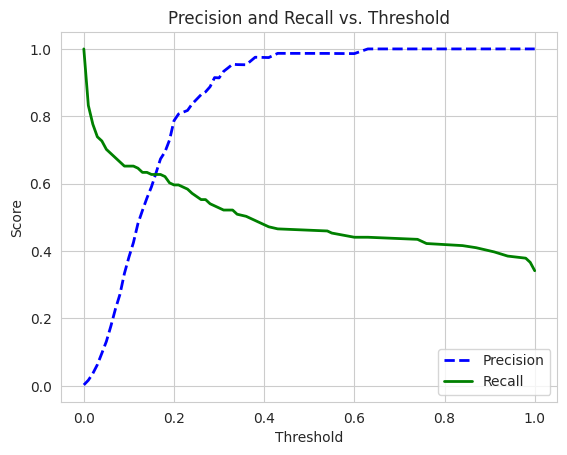

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

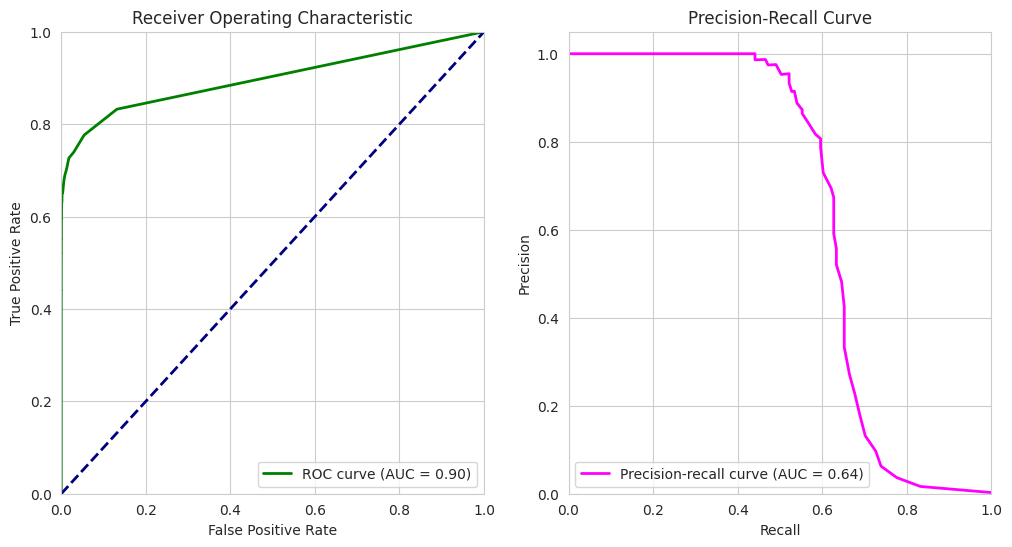

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.0])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.2f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")